<a id="top"></a>
# **7.1 Propagation of a straight crack**

[![title](../fig/bmcs_video.png)](https://moodle.rwth-aachen.de/mod/page/view.php?id=643780)&nbsp;part 1

<div style="background-color:lightgray;text-align:left"> <img src="../icons/start_flag.png" alt="Previous trip" width="50" height="50">
    &nbsp; &nbsp; <b>Starting point</b> </div> 

In the notebook [6.3](../tour6_energy/6_3_localized_energy_dissipation.ipynb#top) we have analyzed the correspondence between the damage function inducing softening and the propagation of discontinuity macroscopically observable as debonding in a pullout test. We mentioned the correspondence between the locally and globally energy evaluated energy dissipation indicating the energy dissipated at a material point can be used to estimate the total amount of dissipated energy by relating it to a localized crack of a known known surface area. In case of an interface area between two material components, like CFRP sheet and concrete, the area is well defined.
Let us now apply the same concept to a crack propagation through a concrete specimen. Even though additional aspects, like two-dimensional stress and strains states, need to be considered, the general concept of energy dissipation introduced previously remains the similar. 

<div style="background-color:lightgray;text-align:left"> <img src="../icons/destination.png" alt="Previous trip" width="50" height="50">
    &nbsp; &nbsp; <b>Where are we heading</b> </div> 

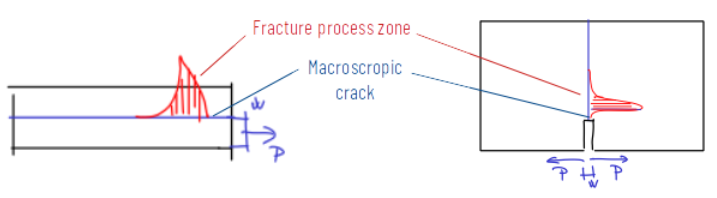

In the present notebook we apply the damage model inducing material softening to a two-dimensional case of stable crack propagation. In particular, we are going to use the three-point bending test as a means of  rendering an elementary crack-propagation scenario, namely a straight crack propagating through a cross section. After discussing the test setup, we provide the test results in terms of load-deflection curve. Then, we will construct a numerical model that can reproduce such a behavior. Similarly to the previous lecture, we will consider the link between fracture and damage concepts that are both included in any finite element computation involving strain-softening material behavior

# **Why notched three-point bending test?**

An isolated tensile crack propagation can be initiated using a notched specimen. The most common configurations used to study the cracking behavior for a tensile crack denoted as mode I are the wedge splitting test and the notched, three-point bending test. Both these tests aim to characterize the material behavior in terms of the softening law describing the relation between the tensile stress transmitted across the localization zone and the corresponding crack opening. 

Due to its simplicity, three-point-bending test on a notched concrete has become a standard (RILEM) to determine the fracture energy $G_\mathrm{f}$ characterizing the cracking behavior of concrete. The test induces a single crack in the notched section propagating straight upwards from the notch in a stable manner. The energy is dissipated in a local region in the crack vicinity so that it can be directly ascribed to the area of emerging crack surface. 

The numerical simulation of this model can be readily performed using the material model with the damage function presented in notebook [5.1](../tour5_damage_bond/5_1_Introspect_Damage_Evolution_Damage_initiation.ipynb). An example of the geometry and boundary conditions of the three-point bending test is provided by the  [Petersson (1982)](https://portal.research.lu.se/portal/files/4705811/1785208.pdf) test series using the following setup.

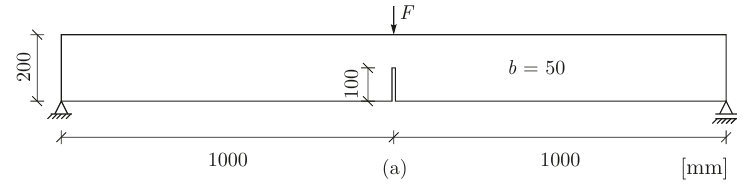

# **Boundary value problem and its FE discretization**

The numerical model simulating this test is assuming a [plain stress](https://en.wikipedia.org/wiki/Plane_stress) described by the stress tensor with the enumeration of spatial dimensions using the index variables $a, b$ = [1,2]
$$
\sigma_{ab}
= 
\left[
\begin{array}{cc}
\sigma_{11} & \sigma_{12} \\
\sigma_{21} & \sigma_{22}
\end{array}
\right]
$$  
and $\sigma_{33} = \sigma_{13} = \sigma_{23} = 0$. The finite element discretization in this model applies the symmetry condition at the middle section of the beam. Upon loading loading, the damage will localize
at the tip of the notch and propagate upwards.

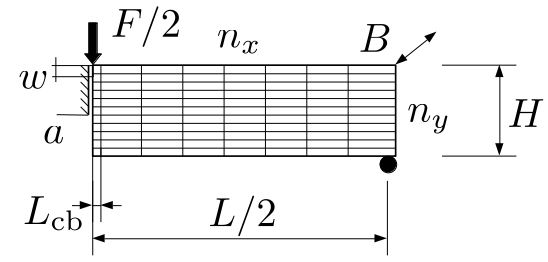

The discretization is using quadrilateral finite elements with bilinear shape functions. A fineness of the regular mesh is defined by the number of elements in $x$ and $y$ directions denoted as `n_e_x` and `n_e_y`, respectively. A maximum deflection is given by the parameter `w_max`. The maximum number of iterations to find an equilibrium within a single load increment is controlled by the parameter `k_max`.

In [1]:
%matplotlib widget
from bmcs_bending.bending3pt_2d import BendingTestModel
from ibvpy.tmodel.mats2D import MATS2DScalarDamage
bt = BendingTestModel(material_model='scalar damage', 
                      n_e_x=6, n_e_y=16, w_max=-2, k_max=500)
bt.time_line.step=0.03
bt.history.warp_factor=100 # multiplier for displacement plotting
bt.cross_section.trait_set(B=50)
bt.geometry.trait_set(L=2000, H=200, a=100, L_cb=1);

# **Material model**

Elastic material matrix is defined with the parameters `E` and `nu`. Note that the lateral
deformation is switched off by setting `nu = 0.0` here. This choice is induced by the need to 
avoid the spurious failure of the compression zone in the final stage of simulation. 
This "numerical trick" is justified by the need to keep the model simple. The damage evolution in response to tensile strain is reflected relatively well, so that the model is sufficient to demonstrate the evaluation of fracture energy upon tensile crack propagation.

In [2]:
E = 30000
bt.material_model_.trait_set(E = E, nu = 0.0); # note nu = 0.0 to avoid compressive failure

## Damage function

The exponential damage function with the two parameters $\kappa_0$ defining the onset of damage and $\kappa_\mathrm{f}$ controlling the slope of the exponential softening branch at the onset of damage presented in notebook [5.1](../tour5_damage_bond/5_1_Introspect_Damage_Evolution_Damage_initiation.ipynb#exp_slope). Assuming the concrete tensile strength $f_\mathrm{ct} = 3.3 \mathrm{[MPa]}$, we can set the parameters $\kappa_0$ and the slope of the softening branch $\kappa_\mathrm{f}$ as follows

In [3]:
f_ct = 3.3
kappa_0 = f_ct / E
bt.material_model_.omega_fn = 'exp-slope'
bt.material_model_.omega_fn_.trait_set(kappa_0=kappa_0, kappa_f=0.02)

To achieve a fast convergence of the nonlinear simulation, the tangential algorithmic stiffness will be activated by setting the parameter `D_alg = 1`. Note that `D_alg = 0` corresponds to the secant stiffness which requires large number of iterations but can cope with large stress redistribution within the simulated domain. 

In [4]:
bt.material_model_.trait_set(D_alg=1, eps_max=1);

The important feature of the provided damage model is the possibility to evaluate the fracture energy, i.e. the amount of energy to achieve a zero stress state. This value can be accessed as a `G_f` property of the material model.

In [5]:
bt.material_model_.G_f

0.06435413610343986

## Strain norm

[![title](../fig/bmcs_video.png)](https://moodle.rwth-aachen.de/mod/page/view.php?id=643780)&nbsp;part 2

The scalar damage material model can combine different measures of equivalent strain with a different type of damage function. 
The task of the equivalent strain norm is to transform the two-dimensional strain tensor 
$$
\varepsilon_{ab}
= 
\left[
\begin{array}{cc}
\varepsilon_{11} & \varepsilon_{12} \\
\varepsilon_{21} & \varepsilon_{22}
\end{array}
\right]
$$  
to a scalar value $\kappa$. The equivalent strain norms already mentioned in the notebook [5.1](../tour5_damage_bond/5_1_Introspect_Damage_Evolution_Damage_initiation.ipynb#strain_norm) play the role of an elastic limit. Their visual inspection
can be performed using the model component of the material model `MATSScalarDamage`. 

In [6]:
bt.material_model_.strain_norm = 'Rankine' # 'Masars', 'Energy'
bt.material_model_.strain_norm_.interact()

Further strain norms can be chosen from the options
 - Rankine strain norm
 - Masar's strain norm
 - Energy norm
 
These norms have to be combined with an elastic threshold to distinguish the elastic and inelastic domains.
Inspect the visual representation of the equivalent strain measure by changing the selector above from `Rankine` to either `Masars` or `Energy`

The mathematical expression delivering the three provided strain norms look as follows:

**Masars strain norm:**
$$
 \kappa = \sqrt{ \sum_{I=1}^{3} \left< \varepsilon_I \right>^2 } =  \sqrt{ \left< \varepsilon_I \right>^2\delta_{II} }
$$
where $\varepsilon_I$ denotes the principal strains. The second version of the expression uses the index notation with a summation over an index that repeats in a product of two terms (see [Einstein summation rule](https://en.wikipedia.org/wiki/Einstein_notation)). The symbol $\delta_{II}$ represents an identity mapping called Kronecker delta, with $\delta_{IJ} = 1$ if $I=J$ and $\delta_{IJ} = 0$ otherwise.  

**Rankine strain norm:**
$$
\kappa = \dfrac{1}{E} \max_{I=1}^{3} \sigma_I
$$
where $\sigma_I$ are the principal values of the stress tensor, i.e. 
$$\sigma_{ab} = D^\mathrm{el}_{abcd} \varepsilon_{cd}
$$

**Energy norm**
$$
\kappa = \dfrac{1}{E} \sqrt{ \boldsymbol{\varepsilon} : \boldsymbol{D}^\mathrm{el}: \boldsymbol{\varepsilon} }
 = \dfrac{1}{E} \sqrt{ \varepsilon_{ab} D^\mathrm{el}_{abcd} \varepsilon_{cd} }
$$
representing circular or spherical shape of the elastic domain in 2D or 3D, respectively.

## The importance of algorithmic stiffness

The rate of convergence strongly depends on the quality of prediction of the stress state for the next step. The parameter `D_alg` can be used ton control the calculation by choosing between the secant and algorithmic, tangential stiffness. Derivation of the material stiffness might appear tedious at the first sight but in fact, it only requires the evaluation of the chain derivatives involved in the constitutive law. 

Let us exemplify the derivation of the algorithmic material stiffness on the example of the isotropic damage model. In contrast to the version presented in notebook [5.1]() for the bond-slip law, we are applying the damage model to a 2D continuum described by the strain and stress tensor tensors $\boldsymbol{\varepsilon} = \varepsilon_{ab}$ 
and $\boldsymbol{\sigma} = \sigma_{ab}$, where letter indexes $a,b,c,d = [1,2]$ enumerate the orthogonal directions of the cartesian coordinate system. For example, $\varepsilon_{11} = \varepsilon_{xx}$. Then the stress-strain relation prescribed by the damage model is given as 

\begin{align}
\sigma_{ab} = (1 - \omega(\kappa(\varepsilon_{cd}))) D_{abcd}^\mathrm{el} \varepsilon_{cd}
\end{align}

where $\kappa(\varepsilon_{cd})$ represents the equivalent strain described above, and $\omega(\kappa)$ represents the particular damage function. The algorithmic stiffness is derived as the derivative of the above stress tensor with respect to a strain tensor. This means that every stress component must be differentiated with respect to every strain component. The result of this expression is a rank 4 tensor $D_{abcd}$ describing the instantaneous stiffness of a material point undergoing damage. The resulting expression delivers the material stiffness in the following form

\begin{align}
D_{abcd} &= \dfrac{\mathrm{d} \sigma_{ab}}{\mathrm{d}\varepsilon_{cd}} \\
& =
\left(1 - \omega(\kappa(\varepsilon_{cd}))\right) D_{abcd}^\mathrm{el} -
\dfrac{\mathrm{d} \omega}{\mathrm{d}\kappa}
\dfrac{\partial \kappa}{\partial\varepsilon_{cd}} D_{abcd}^\mathrm{el} \, \varepsilon_{cd} \, \theta_\mathrm{alg,stiff}
\end{align}

The parameter `D_alg` is denoted here as $\theta_{\mathrm{alg,stiff}}$ and is provided as an input parameter in the material model. By setting this parameter to zero, the second term in the above expression is canceled. Then, only the secant stiffness is available. The importance of the algorithmic stiffness can be studied in the simulation of the bending test. The default value  $\theta_\mathrm{alg,stiff} = 1$ is activating the algorithmic stiffness. By setting $\theta_\mathrm{alg,stiff} = 0$ one can see the strong reduction of the performance.

However, in some situation, for example when simulating simultaneous crack propagation in reinforced specimens the tangential stiffness might induce divergence. The reason for such behavior is the fact that the bond stress can rapidly change the sign. In these situations, advanced control strategies are required.

# **Simulation example**

[![title](../fig/bmcs_video.png)](https://moodle.rwth-aachen.de/mod/page/view.php?id=643780)&nbsp;part 3

Fist, let us ensure that the `Rankine` strain norm is used in the model. 

In [7]:
bt.material_model_.strain_norm='Rankine'
bt.reset()
bt.run()

In [8]:
bt.interact()

## Evaluation of energy dissipation

If a standard finite element discretization is combined with a softening material model, 
 1. it will always induce localization into a band of finite elements at the propagating stress concentration. 
 2. the area below the stress strain curve of a material model represents the energy dissipated by a unit volume of a material.
 
As a consequence, the total amount of the dissipated energy can be calculated as a product of the specific dissipation energy $G_\mathrm{f}$ $\mathrm{[J/mm^3]}$ and the volume of elements constituting the crack band $V_\mathrm{diss}$ $\mathrm{[mm^2]}$. In general, 
$$
G_\mathrm{total} = G_\mathrm{f} V_\mathrm{diss}
$$
In a notched bending test, the crack band is running from the notch straight through the cross section. Therefore, it is possible to directly calculate the dissipative volume $V_\mathrm{diss}$ as
$$
 V_\mathrm{diss} = (H - a) B L_\mathrm{cb}
$$

In [9]:
V_diss = (bt.geometry.H - bt.geometry.a)*bt.cross_section.B * bt.geometry.L_cb
V_diss

5000.0

The specific energy $G_\mathrm{f}$ is available as an attribute of the material model. It has the value

In [10]:
bt.material_model_.G_f # N/mm

0.06435413610343986

Thus, the total dissipated energy should read

In [11]:
G_total = V_diss * bt.material_model_.G_f
G_total

321.7706805171993

The total dissipated energy is available in the `hist` model component as a last element of the recorded array, so that we can pick it using the index `-1`

In [12]:
import numpy as np
bt.hist.W_t[-1]

282.5506041549446

# **Parametric study**

[![title](../fig/bmcs_video.png)](https://moodle.rwth-aachen.de/mod/page/view.php?id=643780)&nbsp;part 4

What happens when we change something? In particular, what happens if we change the volume of the dissipative zone $V_\mathrm{diss}$?

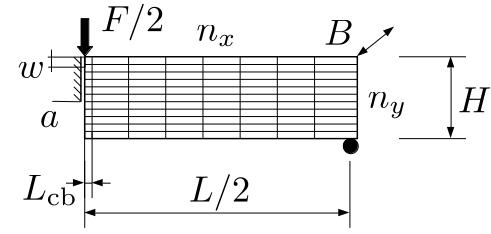

<div style="background-color:lightgray;text-align:left"> <img src="../icons/run.png" alt="Run" width="40" height="40">
    &nbsp; &nbsp; <b>Run in a loop along the changing width of the crack band</b> </div>

In [20]:
Fw_dict = {}
G_dict = {}

In [21]:
L_cb_list = [1, 2, 4]
for L_cb in L_cb_list:
    print('calculating F-w and G for crack band L_cb = %g [mm]' % L_cb)
    bt.reset()
    bt.geometry.L_cb = L_cb
    bt.run()
    Fw_dict[L_cb] = bt.hist['Fw'].Fw
    G_dict[L_cb] = bt.hist['energy'].G_t[-1]

calculating F-w and G for crack band L_cb = 1 [mm]
calculating F-w and G for crack band L_cb = 2 [mm]
calculating F-w and G for crack band L_cb = 4 [mm]


<div style="background-color:lightgray;text-align:left"> <img src="../icons/view.png" alt="Run" width="40" height="40">
    &nbsp; &nbsp; <b>... let us put the results into a diagram</b> </div>

In [15]:
import matplotlib.pylab as plt
fig, (ax, ax_G) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)
fig.canvas.header_visible=False
for L_cb, (F, w) in Fw_dict.items():
    ax.plot(-w,-F,label='L_cb = %g' % L_cb)
ax.legend()
ax.set_xlabel(r'$w$ [mm]');
ax.set_ylabel(r'$F$ [N]');
G_list = [G_dict[L_cb] for L_cb in L_cb_list]
ax_G.plot(L_cb_list, G_list, marker='H')
ax_G.set_xlabel(r'$L_\mathrm{cb}$ [mm]')
ax_G.set_ylabel(r'$G_\mathrm{total}$ [kJ]');
ax_G.set_ylim(ymin=0, ymax=1.1 * np.max(G_list))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.0, 575.4982493017241)

<div style="background-color:lightgray;text-align:left"> <img src="../icons/caveat.png" alt="Run" width="40" height="40">
    &nbsp; &nbsp; <b>... mesh dependent results</b> </div>

By changing the element size within the crack band we change the volume of material which dissipates energy. As observed, a larger element size leads to a larger amount of energy dissipation which makes the structural response more ductile. Why does it happen? The displacement approximated within a finite element is continuous function. Using low-order elements, with, e.g. bilinear shape functions, means that the strain within the element is of even lower order, i.e. constant or linear. Therefore, strain cannot localize within a smaller size than the size of the element through which the crack propagates. As a consequence, upon softening, an element exhibits a nearly uniform increasing strain which results in energy dissipation over its whole volume. The obtained results are therefore biased by the mesh size which documents an ill-posed model behavior. 

There are several techniques how to avoid this mesh dependency. The principle idea of these so called regularization methods is to ensure a prescribed amount of energy dissipation upon localization. The most simple technique is sketched and demonstrated in the following parametric study. 

# **How to make the results mesh independent?**

The finite element codes solve this problem by adjusting the slope of the softening branch to keep the energy dissipation within a crack band invariant for a changed size of an element. This is the most common technique used in commercial finite element codes.

The above examples explain that the correspondence between the local value of $G_\mathrm{f}$ and the total energy $G_\mathrm{total}$ is established by realizing that energy dissipation is linked with the crack propagation. Indeed, if $G_\mathrm{f}$ is related to a unit area of the crack surface, the total energy dissipation in the whole test with a localized crack of the area $V_\mathrm{diss}$ is 
obtained as
$$
G_\mathrm{total} = G_\mathrm{f} V_\mathrm{diss}.
$$

In the above example, the crack was represented by a band of elements with the width specified by the $L_\mathrm{cb}$ model parameter. Since the crack developed over the whole notched cross section, we can express the dissipative volume as

$$
 V_\mathrm{diss} = (H - a) B L_\mathrm{cb}
$$

To ensure that the amount of dissipated energy for a changed $V_\mathrm{diss}$ due to different mesh size does not change, we need to correspondingly adjust effective value of dissipated energy in depending on $L_\mathrm{cb}$. In other words, we need to introduce
$$
G_\mathrm{f}^{L_\mathrm{cb}} = \dfrac{G_\mathrm{f}}{L_\mathrm{cb}}
$$
so that the total energy becomes independent on $L_\mathrm{cb}$
$$
 G_\mathrm{total} = G_\mathrm{f}^{L_\mathrm{cb}} (H-a) B L_\mathrm{cb}
 = G_\mathrm{f} (H-a) B.
$$

This scaling must be achieved by adjusting the material parameters of the model depending on the size of the discretization element $L_\mathrm{cb}$. In present model we use the exponential damage function with the two parameters $\kappa_0$ and $\kappa_\mathrm{f}$ controlling the onset of damage and the slope of the descending branch, respectively. The above specified scaling of energy dissipation can be achieved by scaling the parameter 
$$
\kappa_{\mathrm{f}}^{L_\mathrm{cb}} = \dfrac{\kappa_{\mathrm{f}}}{L_\mathrm{cb}}
\implies
G_\mathrm{f}^{L_\mathrm{cb}} \approx \dfrac{G_\mathrm{f}}{L_\mathrm{cb}}
$$.

To verify, that this scaling correspondingly affects the effective amount of energy dissipation by evaluating the value of $G_{\mathrm{f}}^{L_\mathrm{cb}}$ for the values of $L_\mathrm{cb} = [1,2,3,4]$. These values should lead to the corresponding fractions [$1, \frac{1}{2}, \frac{1}{3}, \frac{1}{4}$] of $G_\mathrm{f}$. Assuming the reference value $\kappa_f$ corresponding to the length $L_\mathrm{cb} = 1$ we obtain

In [16]:
kappa_f = 0.0336 # reference value of kappa for L_cb = 1
kappa_f_range = kappa_f / np.array([1,2,3,4])
G_f_range = []
for kappa_f_ in kappa_f_range:
    bt.material_model_.omega_fn_.kappa_f = kappa_0 + kappa_f_
    G_f_range += [bt.material_model_.G_f]
np.array(G_f_range) / G_f_range[0]

array([1.        , 0.49416785, 0.32557841, 0.24129989])

Which roughly correspond to the desired fractions

Let us now apply this scaling by changing a single line in the parametric study. This line is denoted as `REGULARIZATION`.

In [17]:
Fw_reg_dict = {}
G_reg_dict = {}

In [18]:
L_cb_list = [1, 2, 4]
kappa_f = 0.0336
for L_cb in L_cb_list:
    print('calculating F-w and G_total for crack band L_cb = %g [mm]' % L_cb)
    bt.reset()
    bt.geometry.L_cb = L_cb # change the size of the crack band
    bt.material_model_.omega_fn_.kappa_f = kappa_f / L_cb #### REGULARIZATION ####
    print('with scaled effective specific dissipation energy G_f', bt.material_model_.G_f)
    try: 
        bt.run()
    except StopIteration:
        print('simulation interupted due to slow convergence', L_cb)
    Fw_reg_dict[L_cb] = bt.hist['Fw'].Fw
    G_reg_dict[L_cb] = bt.hist['energy'].G_t[-1]

calculating F-w and G_total for crack band L_cb = 1 [mm]
with scaled effective specific dissipation energy G_f 0.1092317778327407
calculating F-w and G_total for crack band L_cb = 2 [mm]
with scaled effective specific dissipation energy G_f 0.053795255499048136
calculating F-w and G_total for crack band L_cb = 4 [mm]
with scaled effective specific dissipation energy G_f 0.02608239216637152


In [19]:
import matplotlib.pylab as plt
fig, (ax, ax_G) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)
fig.canvas.header_visible=False
for L_cb, (F, w) in Fw_reg_dict.items():
    ax.plot(-w,-F,label='L_cb = %g' % L_cb)
ax.legend()
ax.set_xlabel(r'$w$ [mm]');
ax.set_ylabel(r'$F$ [N]');
G_list = [G_reg_dict[L_cb] for L_cb in L_cb_list]
ax_G.plot(L_cb_list, G_list, marker='H')
ax_G.set_xlabel(r'$L_\mathrm{cb}$ [mm]')
ax_G.set_ylabel(r'$G_\mathrm{total}$ [kJ]');
ax_G.set_ylim(ymin=0, ymax=1.1 * np.max(G_list));

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Even though the difference in the predicted peak of the load deflection curve shown left is still apparent, the amount of dissipated energy up to the control displacement of $w=2$ mm does not change with the element size any more. Let us remark that the applied scaling of $\kappa_\mathrm{f}$ was only approximate. A more sophisticated scaling and a smaller size of load increment would be required to achieve even a better match of the load deflection curves.

The described kind of scaling can be found in the most common finite-element codes. In the present example, the position and profile of the crack was known a-priori. Finite element codes implementing material models with softening behavior must implement a general procedure for the described crack band regularization. This regularization is performed in each material point by including the size of the containing element and the orientation of principle strains to reflect the width of the softening zone correctly.

The described procedure can be regarded as a _quick fix_. It makes the standard finite-element method applicable to simulation cracking for problems with straight crack evolution, i.e. tensile cracks. It is, however, insufficient for crack propagation with non-negligible shear stress within the localization zone. Indeed, most of the commercially available software based on continuous finite-element approximation of the displacement field cannot correctly predict the shear crack propagation.  Pragmatic solutions, including an additional parameter like a shear retention factor, are provided in some software packages (ATENA). 

More advanced methods address the problem of mesh independence using 
 - Nonlocal averaging of state variables over a defined size of a process zone
 - Gradient methods of damage and plasticity including the gradient of state variables into the constitutive law

They are mentioned here for completeness and as an optional further reading.

**Note the dimensionality of $G_\mathrm{f}$:** To be precise, let us note that in contrast to the example shown in notebook [6.3](tour6_energy/6_3_localized_energy_dissipation.ipynb) for the CFRP pullout simulation, the damage function was applied to the bond-slip law, describing the behavior of a unit area of the interface. On the other hand, in the present notebook, we applied the damage function in a two-dimensional constitutive law. 

<div style="background-color:lightgray;text-align:left;width:45%;display:inline-table;"> <img src="../icons/previous.png" alt="Previous trip" width="50" height="50">
    &nbsp; <a href="../tour6_energy/6_3_localized_energy_dissipation.ipynb#top">6.3 Softening and fracture energy</a> 
</div><div style="background-color:lightgray;text-align:center;width:10%;display:inline-table;"> <a href="#top"><img src="../icons/compass.png" alt="Compass" width="50" height="50"></a></div><div style="background-color:lightgray;text-align:right;width:45%;display:inline-table;"> 
    <a href="../tour7_cracking/7_2_fracture_energy_ident.ipynb#top">7.2 Identification of fracture energy</a>&nbsp; <img src="../icons/next.png" alt="Previous trip" width="50" height="50"> </div> 